In [ ]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import spearmanr

import matplotlib.pyplot as plt

In [ ]:
DATA_PATH = "/content/wildfire_dataset_GBDG_FFDRI.csv"

df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
df.head()

Shape: (598, 32)


,label,date,season,lon,lat,tp_mm,rne,tmean,tmax,tmin,...,fri_norm,fri_grade,range,is_coastal,zone,NDVI,sunlight_era5,matched_gps_index,matched_distance_km,피해면적_합계
0,1,2015-02-06,spring,128.404838,36.308010,0.047146,1.0,0.326968,5.496776,-2.475430,...,0.221147,Low,≤0.50,0,내륙,0.474180,14.678464,417,2.134418,0.40
1,1,2015-02-07,spring,129.048609,36.592477,0.072354,1.0,-0.521327,3.718820,-8.392571,...,0.269640,Low,≤0.50,1,해안권,0.158538,11.668924,416,3.641451,0.01
2,1,2015-02-09,spring,129.207457,36.566791,0.198494,1.0,-3.827299,-1.988971,-10.569216,...,0.129231,Low,≤0.50,1,해안권,0.383000,15.693440,415,1.298978,0.05
3,1,2015-02-10,spring,128.391712,35.757440,0.024236,1.0,1.474569,8.040005,-2.722052,...,0.131141,Low,≤0.50,0,내륙,0.510088,14.860708,-1,NaN,0.00
4,1,2015-02-10,spring,128.768221,35.935804,0.010314,1.0,1.505291,7.682582,-2.458128,...,0.061488,Low,≤0.50,0,내륙,0.650974,14.800496,414,1.250197,0.20


In [ ]:
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

In [ ]:
target_col = "피해면적_합계"
df["target_log"] = np.log(df[target_col] + 0.01)

In [ ]:
feature_cols = [
    "tmean", "rh", "eh", "wspd", "tp_mm", "rne",
    "sunlight_era5", "NDVI", "pdwi", "dwi",
    "fmi", "tmi", "ffdri"
]

X = df[feature_cols]
y = df["target_log"]

print("입력변수:", feature_cols)
print("X shape:", X.shape, "y shape:", y.shape)

입력변수: ['tmean', 'rh', 'eh', 'wspd', 'tp_mm', 'rne', 'sunlight_era5', 'NDVI', 'pdwi', 'dwi', 'fmi', 'tmi', 'ffdri']
X shape: (598, 13) y shape: (598,)


In [ ]:
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, shuffle=True
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=0.1765,  # 0.1765 * 0.85 ≈ 0.15 overall
    random_state=42, shuffle=True
)

print("Train:", X_train.shape)
print("Valid:", X_valid.shape)
print("Test:", X_test.shape)


Train: (418, 13)
Valid: (90, 13)
Test: (90, 13)


# Randomforest

In [ ]:
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=6,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, min_samples_leaf=5, n_estimators=300,
                      n_jobs=-1, random_state=42)

In [ ]:
def evaluate(model, X, y_true, name=""):
    y_pred_log = model.predict(X)


    mae_log = mean_absolute_error(y_true, y_pred_log)
    rmse_log = np.sqrt(mean_squared_error(y_true, y_pred_log))
    r2_log = r2_score(y_true, y_pred_log)
    spear_log, _ = spearmanr(y_true, y_pred_log)


    y_true_raw = np.exp(y_true) - 0.01
    y_pred_raw = np.exp(y_pred_log) - 0.01

    mae = mean_absolute_error(y_true_raw, y_pred_raw)
    rmse = np.sqrt(mean_squared_error(y_true_raw, y_pred_raw))
    r2 = r2_score(y_true_raw, y_pred_raw)
    spear, _ = spearmanr(y_true_raw, y_pred_raw)

    print(f"\n=== {name} 평가 ===")
    print(f"[Log]  MAE={mae_log:.4f}, RMSE={rmse_log:.4f}, R2={r2_log:.4f}, Spearman={spear_log:.4f}")
    print(f"[Raw]  MAE={mae:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}, Spearman={spear:.4f}")

    return y_pred_raw, y_pred_log


# Randomforest 결과 MAE, RMSE, R2

In [ ]:
train_pred, _ = evaluate(rf, X_train, y_train, "Train")
valid_pred, _ = evaluate(rf, X_valid, y_valid, "Valid")
test_pred,  _ = evaluate(rf, X_test,  y_test,  "Test")



=== Train 평가 ===
[Log]  MAE=0.9404, RMSE=1.0964, R2=0.4291, Spearman=0.8396
[Raw]  MAE=0.1094, RMSE=0.2247, R2=0.0257, Spearman=0.8396

=== Valid 평가 ===
[Log]  MAE=1.1721, RMSE=1.3608, R2=-0.0805, Spearman=0.0504
[Raw]  MAE=0.0857, RMSE=0.1509, R2=-0.1183, Spearman=0.0504

=== Test 평가 ===
[Log]  MAE=1.4162, RMSE=1.6084, R2=-0.0813, Spearman=-0.1140
[Raw]  MAE=0.1479, RMSE=0.2759, R2=-0.1735, Spearman=-0.1140


        date  피해면적_합계  pred_area  danger_index
0 2015-02-06     0.40   0.044205     21.531252
1 2015-02-07     0.01   0.029359     12.390160
2 2015-02-09     0.05   0.037240     17.242307
3 2015-02-10     0.00   0.011982      1.690344
4 2015-02-10     0.20   0.054182     27.674398


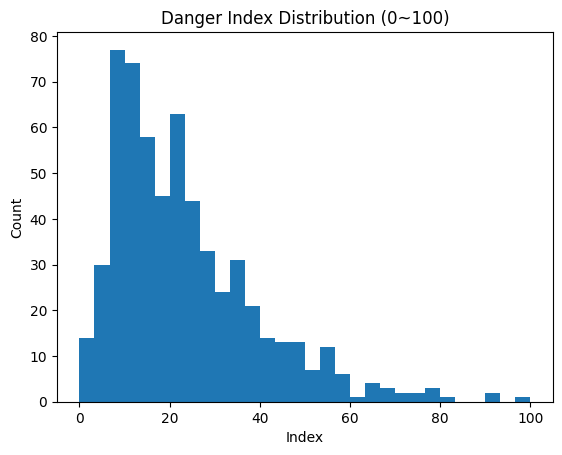

In [ ]:
all_pred_log = rf.predict(X)
all_pred_raw = np.exp(all_pred_log) - 0.01

df["pred_area"] = all_pred_raw


min_val, max_val = df["pred_area"].min(), df["pred_area"].max()
df["danger_index"] = 100 * (df["pred_area"] - min_val) / (max_val - min_val + 1e-9)

print(df[["date", target_col, "pred_area", "danger_index"]].head())


plt.hist(df["danger_index"], bins=30)
plt.title("Danger Index Distribution (0~100)")
plt.xlabel("Index")
plt.ylabel("Count")
plt.show()

## ElasticNET

In [ ]:
DATA_PATH = "/content/wildfire_dataset_GBDG_FFDRI.csv"  # 경로 맞게 수정

df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
df.head()

Shape: (598, 32)


,label,date,season,lon,lat,tp_mm,rne,tmean,tmax,tmin,...,fri_norm,fri_grade,range,is_coastal,zone,NDVI,sunlight_era5,matched_gps_index,matched_distance_km,피해면적_합계
0,1,2015-02-06,spring,128.404838,36.308010,0.047146,1.0,0.326968,5.496776,-2.475430,...,0.221147,Low,≤0.50,0,내륙,0.474180,14.678464,417,2.134418,0.40
1,1,2015-02-07,spring,129.048609,36.592477,0.072354,1.0,-0.521327,3.718820,-8.392571,...,0.269640,Low,≤0.50,1,해안권,0.158538,11.668924,416,3.641451,0.01
2,1,2015-02-09,spring,129.207457,36.566791,0.198494,1.0,-3.827299,-1.988971,-10.569216,...,0.129231,Low,≤0.50,1,해안권,0.383000,15.693440,415,1.298978,0.05
3,1,2015-02-10,spring,128.391712,35.757440,0.024236,1.0,1.474569,8.040005,-2.722052,...,0.131141,Low,≤0.50,0,내륙,0.510088,14.860708,-1,NaN,0.00
4,1,2015-02-10,spring,128.768221,35.935804,0.010314,1.0,1.505291,7.682582,-2.458128,...,0.061488,Low,≤0.50,0,내륙,0.650974,14.800496,414,1.250197,0.20


In [ ]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, shuffle=True
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=0.1765,  # 0.1765 * 0.85 ≈ 0.15 overall
    random_state=42, shuffle=True
)

print("Train:", X_train.shape)
print("Valid:", X_valid.shape)
print("Test:", X_test.shape)

Train: (418, 13)
Valid: (90, 13)
Test: (90, 13)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled  = scaler.transform(X_test)
X_all_scaled   = scaler.transform(X)

In [ ]:
from sklearn.linear_model import ElasticNetCV

enet = ElasticNetCV(
    l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9],
    alphas=np.logspace(-4, 2, 50),
    cv=5,
    random_state=42
)

enet.fit(X_train_scaled, y_train)

print("Best alpha:", enet.alpha_)
print("Best l1_ratio:", enet.l1_ratio_)

Best alpha: 100.0
Best l1_ratio: 0.1


In [ ]:
def eval_split(model, Xs, y_true, name=""):
    y_pred_log = model.predict(Xs)

    # 로그 스케일
    mae_log = mean_absolute_error(y_true, y_pred_log)
    rmse_log = np.sqrt(mean_squared_error(y_true, y_pred_log))
    r2_log = r2_score(y_true, y_pred_log)
    spear_log, _ = spearmanr(y_true, y_pred_log)

    # 원 스케일 변환
    y_true_raw = np.exp(y_true) - 0.01
    y_pred_raw = np.exp(y_pred_log) - 0.01

    mae = mean_absolute_error(y_true_raw, y_pred_raw)
    rmse = np.sqrt(mean_squared_error(y_true_raw, y_pred_raw))
    r2 = r2_score(y_true_raw, y_pred_raw)
    spear, _ = spearmanr(y_true_raw, y_pred_raw)

    print(f"\n=== {name} 평가 ===")
    print(f"[Log] MAE={mae_log:.4f}, RMSE={rmse_log:.4f}, R2={r2_log:.4f}, Spearman={spear_log:.4f}")
    print(f"[Raw] MAE={mae:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}, Spearman={spear:.4f}")

# ElasticNet 결과 MAE, RMSE, R2

In [ ]:
eval_split(enet, X_train_scaled, y_train, "Train")
eval_split(enet, X_valid_scaled, y_valid, "Valid")
eval_split(enet, X_test_scaled,  y_test,  "Test")


=== Train 평가 ===
[Log] MAE=1.2670, RMSE=1.4511, R2=0.0000, Spearman=nan
[Raw] MAE=0.1282, RMSE=0.2460, R2=-0.1670, Spearman=nan

=== Valid 평가 ===
[Log] MAE=1.1792, RMSE=1.3252, R2=-0.0247, Spearman=nan
[Raw] MAE=0.0854, RMSE=0.1502, R2=-0.1082, Spearman=nan

=== Test 평가 ===
[Log] MAE=1.3769, RMSE=1.5481, R2=-0.0018, Spearman=nan
[Raw] MAE=0.1451, RMSE=0.2758, R2=-0.1725, Spearman=nan


/tmp/ipython-input-3594170871.py:8: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spear_log, _ = spearmanr(y_true, y_pred_log)
/tmp/ipython-input-3594170871.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spear, _ = spearmanr(y_true_raw, y_pred_raw)
/tmp/ipython-input-3594170871.py:8: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spear_log, _ = spearmanr(y_true, y_pred_log)
/tmp/ipython-input-3594170871.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spear, _ = spearmanr(y_true_raw, y_pred_raw)
/tmp/ipython-input-3594170871.py:8: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spear_log, _ = spearmanr(y_true, y_pred_log)
/tmp/ipython-input-3594170871.py:17: ConstantInputWarning: An input array is constant; the correlation coefficien

In [ ]:
df["pred_log"] = enet.predict(X_all_scaled)
df["pred_area"] = np.exp(df["pred_log"]) - 0.01

min_v = df["pred_area"].min()
max_v = df["pred_area"].max()
df["danger_index"] = 100 * (df["pred_area"] - min_v) / (max_v - min_v + 1e-9)

df[["date", target_col, "pred_area", "danger_index"]].head()

,date,피해면적_합계,pred_area,danger_index
0,2015-02-06,0.40,0.042193,0.0
1,2015-02-07,0.01,0.042193,0.0
2,2015-02-09,0.05,0.042193,0.0
3,2015-02-10,0.00,0.042193,0.0
4,2015-02-10,0.20,0.042193,0.0
